# How to Access M2T1NXSLV Cloud OPeNDAP Granules using Python
### Author: Chris Battisto
### Date Authored: 03-04-2024

### Timing

Exercise: 5 minutes

### Overview

This notebook demonstrates how to access Cloud OPeNDAP-enabled [MERRA-2 tavg1_2d_slv_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Single-Level Diagnostics V5.12.4 (M2T1NXSLV)](https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary) granules in parallel with Python's <code>requests</code> and <code>Xarray</code> libraries. It queries several granules using the `earthaccess` library, before downloading them to disk, and opening them up as a single Xarray dataset object. Finally, the monthly mean of the 2-meter temperature variable is calculated and plotted to illustrate the unusually high temperatures experienced in the United States during the [March 2012 North American heatwave](https://en.wikipedia.org/wiki/March_2012_North_American_heat_wave).

### Prerequisites

This notebook was written using Python 3.10, and requires:
- Valid [Earthdata Login credentials](https://urs.earthdata.nasa.gov), and the generation of [Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files) including the <code>.netrc</code> and `.dodsrc` files.
- [Xarray](https://docs.xarray.dev/en/stable/)
- [NumPy](https://numpy.org/)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/)
- [Matplotlib](https://matplotlib.org/)
- [Cartopy](https://scitools.org.uk/cartopy/docs/latest/)

#### Optional Anaconda Environment YAML:

This notebook can be run using the ['nasa-gesdisc' YAML file](https://github.com/nasa/gesdisc-tutorials/tree/main/environments/nasa-gesdisc.yml) provided in the 'environments' subfolder.

Please follow the instructions [here](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) to install and activate this environment. 

### Import Libraries

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import os
import time
import earthaccess
import requests
import concurrent.futures
%matplotlib inline


### Query OPeNDAP URLs

We will query the M2T1NXSLV granule OPeNDAP URLs using its short name and version, which can be found on its [dataset landing page](https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary). Then, we will parse out these OPeNDAP links and store them in a list.

In [3]:
results = earthaccess.search_data(
    short_name="M2T1NXSLV",
    version='5.12.4',
    temporal=('2012-03-01', '2012-03-31'),
    bounding_box=(-180, 0, 180, 90)
)

# Parse out URL from request, add to OPeNDAP URLs list for querying multiple granules
od_files = []
for item in results:
    for urls in item['umm']['RelatedUrls']:  # Iterate over RelatedUrls in each request step
        if 'OPENDAP' in urls.get('Description', '').upper():  # Check if 'OPENDAP' is in the Description
            url = urls['URL']
            # Add URL to list
            od_files.append(url)

print('Number of files:', len(od_files))

Number of files: 31


### Add Constraint Expressions for Variable Subsetting, and Download with <code>requests</code>

For Cloud OPeNDAP-enabled granules, [DAP4](https://docs.opendap.org/index.php?title=OPULS_Development#DAP4_Specification) syntax is required for creating constraint expressions if the user wishes to download the granule in a different file format, or for specific variable subsetting.

Below, we create a function called <code>download_granule()</code> that will be called by the ThreadPoolExecutor for downloading the granules in parallel. The function first appends <code>.dap.nc4</code> which is a DAP4 action that will download the granule as a NetCDF4 file. Next, we create our constraint expressions by specifying the variables and slices of those variables we wish to subset.

To explore variables and create links for subsetting, users can access the DAP4 request form (found by appending <code>.dmr.html</code> to the end of the Cloud OPeNDAP granule URL).

***This code also contians methods to skip files that are already downloaded, and will retry failed download requests.***

In [ ]:
def download_granule(url, max_retries=3, retry_delay=5):
    print("Opening " + url)
    
    data_url = f'{url}.dap.nc4'

    # Specify variables for subsetting
    required_variables = {'T2M', 
                          'lon', 
                          'lat', 
                          'time'}

    basename = os.path.basename(data_url)

    # Skip if file already downloaded
    if os.path.exists(basename):
        print(f"File already exists, skipping: {basename}")
        return

    request_params = {'dap4.ce': ';'.join(required_variables)}
    
    for attempt in range(1, max_retries + 1):
        try:
            response = requests.get(data_url, params=request_params, headers={'Accept-Encoding': 'identity'}, timeout=30)
            if response.ok:
                with open(basename, 'wb') as file_handler:
                    file_handler.write(response.content)
                print(f"Downloaded successfully: {basename}")
                return
            else:
                print(f"Request failed (attempt {attempt}): {response.status_code} - {response.text}")
        except Exception as e:
            print(f"Download error on attempt {attempt} for {basename}: {e}")
        
        if attempt < max_retries:
            time.sleep(retry_delay)

    print(f"Failed to download after {max_retries} attempts: {basename}")

with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    executor.map(download_granule, od_files)

### Concatenate and Sum Granules into an Xarray Dataset Object

Next, we can use the <code>open_mfdataset</code> function to concatenate each file into a single Xarray dataset along the 'time' dimension by default.

In [5]:
cloud_data_ds = xr.open_mfdataset('*.dap.nc4')
cloud_data_ds

<xarray.Dataset> Size: 619MB
Dimensions:  (time: 744, lat: 361, lon: 576)
Coordinates:
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 6kB 2012-03-01T00:30:00 ... 2012-03-31T23:...
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
Data variables:
    T2M      (time, lat, lon) float32 619MB dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
Attributes: (12/38)
    History:                             Original file generated: Fri Jul 25 ...
    Comment:                             GMAO filename: d5124_m2_jan10.tavg1_...
    Filename:                            MERRA2_400.tavg1_2d_slv_Nx.20120301.nc4
    Conventions:                         CF-1
    Institution:                         NASA Global Modeling and Assimilatio...
    References:                          http://gmao.gsfc.nasa.gov
    ...                                  ...
    build_dmrpp_metadata.bes:            3.21.0-526
    build_dmrpp_metadata.libdap:         libdap-3.21.0-120
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_Hba0 -f...
    history:                             2025-07-30 17:36:08 GMT hyrax-1.17.1...
    history_json:                        [{"$schema":"https:\/\/harmony.earth...

### Resample and Calculate Mean 2-meter Temperature for March

Next, we will use `resample()` to concatenate the data along the time axis, and `mean()` to calculate the mean temperature for the entire resampled month. Then, to convert from Kelvin to Celsius, we simply subtract each value by 273.15.

In [6]:
temp_mean = cloud_data_ds['T2M'].resample(time = 'ME').mean()[0,:,:]
temp_mean -= 273.15
temp_mean

<xarray.DataArray 'T2M' (lat: 361, lon: 576)> Size: 832kB
dask.array<sub, shape=(361, 576), dtype=float32, chunksize=(91, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
    time     datetime64[ns] 8B 2012-03-31
Attributes:
    long_name:       2-meter_air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    standard_name:   2-meter_air_temperature
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

### Plot the Data

Finally, we use Xarray and Cartopy to create a plot of the mean <code>T2M</code> over the Continental United States.

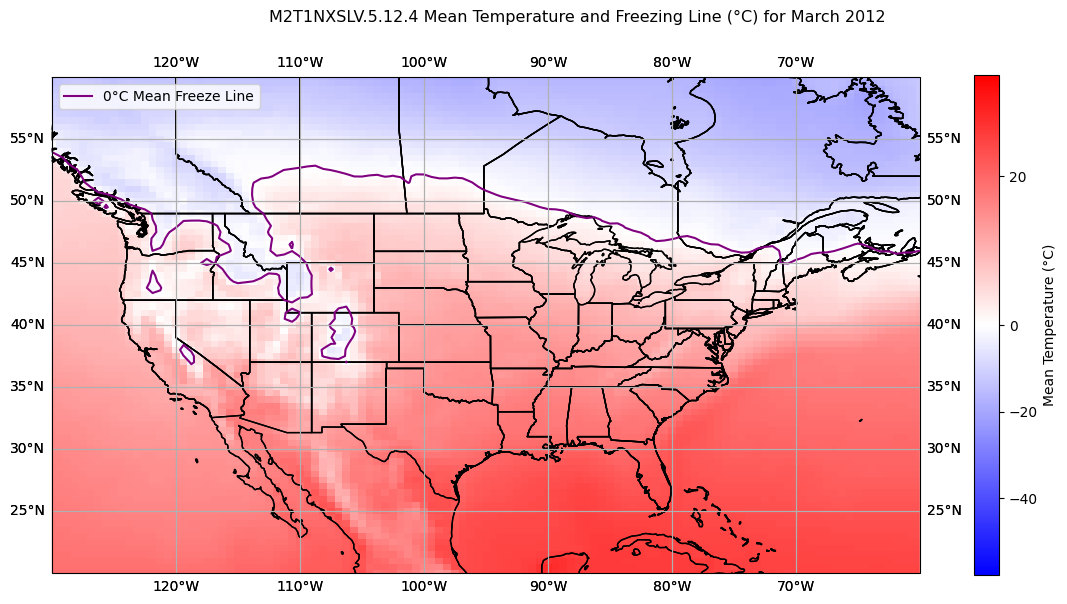

In [7]:
plt.rcParams["figure.figsize"] = (14, 6.5)

# Create subplot object with projection
ax = plt.subplot(projection=ccrs.PlateCarree())

# Normalize the colormap around 0 using TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=temp_mean.min().values, vcenter=0, vmax=temp_mean.max().values)

# Plot temperature using pcolormesh
pm = ax.pcolormesh(temp_mean["lon"], temp_mean["lat"], temp_mean, cmap='bwr', transform=ccrs.PlateCarree(), norm=norm)

# Draw the contour line for the freeze line at 0°C and get a reference to the contour object
plt.contour(temp_mean['lon'], temp_mean['lat'], temp_mean, levels=[0], colors='purple', transform=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.STATES)

# Apply limits to the axis
ax.set_xlim([-130, -60])
ax.set_ylim([20, 60])

# Create a proxy artist for the contour line (for the legend)
freeze_line = mlines.Line2D([], [], color='purple', label='0°C Mean Freeze Line')

# Create the legend and add the proxy artist
plt.legend(handles=[freeze_line], loc='upper left')

# Create color bar and edit label
# Create the color bar based on the mesh object and set its label
cbar = plt.colorbar(pm, ax=ax)
cbar.set_label('Mean Temperature (°C)')

# Add map features
ax.coastlines()
ax.set_title("")
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.STATES)

# Create title for the figure
plt.suptitle("M2T1NXSLV.5.12.4 Mean Temperature and Freezing Line (°C) for March 2012", fontsize=11.5)

plt.show()